In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
import pandas as pd
import scipy.stats as ss
from collections import Counter
import os



In [2]:
# INPUTS:

filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/megadicts"
z_thresh = 4

In [3]:

# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [4]:
def get_BFs(dict):
    BF_list = []
    for sub_dict in dict:
        cell_list = dict[sub_dict].keys()
        for cell in cell_list:
            if dict[sub_dict][cell]['active'] == True:
                tuning_array = np.array(dict[sub_dict][cell]['peak_tuning'])
                max_index_flat = np.argmax(tuning_array)
                max_index_row, _ = np.unravel_index(max_index_flat, tuning_array.shape)
                BF_list.append(max_index_row)
    return BF_list

In [5]:
def get_counts(BF_list):
    counts = Counter(BF_list)
    keys = list(counts.keys())
    keys = sorted(keys)
    counts_sorted = {i: counts[i] for i in keys}
    counts_sorted_density = {k: v / len(BF_list) for k, v in counts_sorted.items()}

    return counts_sorted_density

In [6]:
def get_KL_divergence(pre_dict,post_dict):
    pre = list(pre_dict.values())
    post = list(post_dict.values())

    KL = ss.entropy(pre,post)

    return KL

In [7]:
# Get the BF lists for each cohort
BF_saline_pre = get_BFs(saline_pre)
BF_saline_post = get_BFs(saline_post)
BF_psilo_pre = get_BFs(psilo_pre)
BF_psilo_post = get_BFs(psilo_post)

In [8]:
print(BF_saline_pre)

[5, 7, 9, 7, 0, 1, 0, 0, 0, 3, 6, 7, 2, 10, 2, 11, 7, 0, 7, 3, 0, 0, 0, 4, 2, 7, 5, 9, 7, 4, 3, 3, 1, 3, 0, 3, 7, 5, 8, 11, 9, 11, 0, 5, 6, 0, 9, 5, 3, 6, 0, 6, 6, 6, 6, 10, 1, 2, 10, 3, 8, 4, 11, 4, 7, 10, 6, 0, 6, 3, 0, 4, 1, 6, 7, 7, 11, 3, 11, 3, 0, 3, 0, 3, 2, 2, 4, 9, 5, 7, 6, 5, 5, 2, 0, 0, 4, 1, 8, 0, 0, 8, 5, 3, 11, 4, 5, 3, 6, 11, 6, 9, 2, 9, 3, 11, 4, 4, 0, 10, 0, 11, 0, 0, 10, 0, 5, 11, 0, 2, 1, 1, 10, 4, 8, 7, 5, 0, 3, 8, 0, 3, 0, 4, 5, 7, 0, 5, 2, 4, 8, 6, 1, 2, 7, 0, 8, 8, 9, 3, 5, 2, 6, 0, 3, 5, 7, 8, 2, 0, 3, 11, 3, 0, 2, 8, 3, 10, 6, 3, 2, 9, 0, 3, 4, 9, 8, 8, 0, 7, 2, 4, 5, 7, 1, 5, 2, 3, 4, 0, 8, 2, 3, 1, 7, 7, 5, 3, 4, 3, 11, 9, 11, 3, 8, 6, 2, 3, 6, 0, 6, 7, 5, 2, 7, 2, 11, 4, 0, 3, 7, 0, 2, 7, 2, 2, 5, 0, 4, 1, 7, 4, 4, 5, 1, 3, 11, 3, 8, 4, 7, 4, 3, 10, 3, 7, 7, 5, 0, 0, 0, 1, 0, 5, 2, 5, 1, 8, 4, 9, 0, 5, 7, 8, 4, 2, 6, 6, 3, 0, 6, 3, 7, 3, 3, 0, 6, 6, 5, 0, 3, 0, 4, 10, 0, 1, 0, 11, 0, 4, 3, 0, 5, 3, 0, 7, 5, 3, 11, 3, 3, 2, 0, 3, 3, 0, 3, 7, 0, 7, 11, 7, 4, 6

In [9]:
def get_BF_array(dict):
    BF_array = np.zeros([len(dict.keys()),12])
    for i,sub_dict in enumerate(dict):
        BF_list = []
        countkeys = range(len(dict[sub_dict][next(iter(dict[sub_dict]))]['traces'].keys()))
        cell_list = dict[sub_dict].keys()
        for cell in cell_list:
            if dict[sub_dict][cell]['active'] == True:
                tuning_array = np.array(dict[sub_dict][cell]['peak_tuning'])
                max_index_flat = np.argmax(tuning_array)
                max_index_row, _ = np.unravel_index(max_index_flat, tuning_array.shape)
                BF_list.append(max_index_row)
        BF_counts = get_counts(BF_list)
        for key in countkeys:
            BF_counts.setdefault(key, 0)
        BF_array[i,:] = list(BF_counts.values())
    BF_mean = np.mean(BF_array,axis=0)
    BF_sem = ss.sem(BF_array,axis=0)
    return BF_array,BF_mean,BF_sem

In [10]:
result_pre_psilo = get_BF_array(psilo_pre)
BF_array_pre_psilo,BF_mean_pre_psilo,BF_sem_pre_psilo = result_pre_psilo

result_post_psilo = get_BF_array(psilo_post)
BF_array_post_psilo,BF_mean_post_psilo,BF_sem_post_psilo = result_post_psilo

result_pre_saline = get_BF_array(saline_pre)
BF_array_pre_saline,BF_mean_pre_saline,BF_sem_pre_saline = result_pre_saline

result_post_saline = get_BF_array(psilo_post)
BF_array_post_saline,BF_mean_post_saline,BF_sem_post_saline = result_post_saline

x = np.arange(0,12,1)
ticks = [4.4, 5.4, 6.6, 8.1, 10.0, 12.3, 15.2, 18.7, 23.0, 28.3, 34.9, 42.9]
# plt.figure(figsize=(6,2))
# plt.plot(BF_mean_pre,label='Pre-Saline',color='b')
# plt.plot(BF_mean_post,label='Post-Saline',color='orange')
# plt.errorbar(x,BF_mean_pre,yerr=BF_sem_pre)
# plt.errorbar(x,BF_mean_post,yerr=BF_sem_post)
# plt.xticks(x,ticks,rotation=45)
# plt.ylim(0,0.3)
# plt.ylabel("Probability",labelpad=10)
# plt.xlabel("Frequency (Hz)",labelpad=10)
# # plt.title("Pixels Responsive to Each Frequency (peak response), as a Percentage of \n Total Responsive Pixels, Day 1",pad=10)
# plt.legend()

C:\Users\Conor\AppData\Local\Temp\ipykernel_892\591910148.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0,5,10,15,20],fontsize=14)
C:\Users\Conor\AppData\Local\Temp\ipykernel_892\591910148.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0,5,10,15,20],fontsize=14)


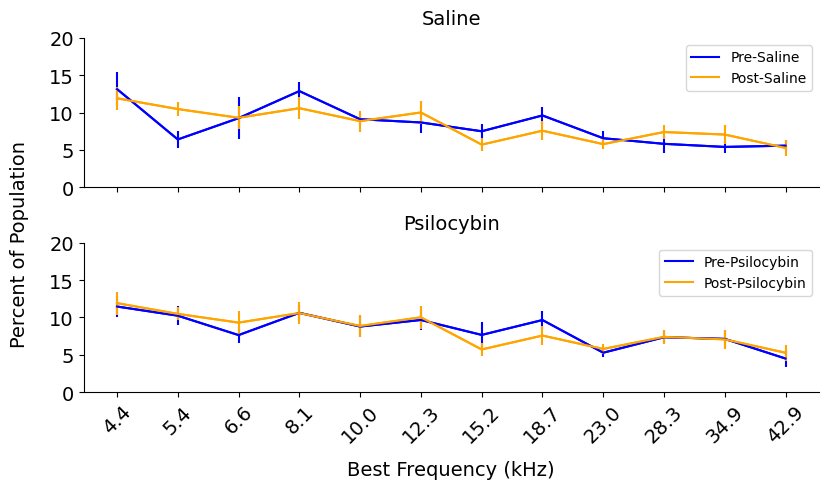

In [11]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# First subplot
ax1.plot(BF_mean_pre_saline, label='Pre-Saline', color='b')
ax1.plot(BF_mean_post_saline, label='Post-Saline', color='orange')
ax1.errorbar(x, BF_mean_pre_saline, yerr=BF_sem_pre_saline, color='b')
ax1.errorbar(x, BF_mean_post_saline, yerr=BF_sem_post_saline, color='orange')
ax1.set_yticklabels([0,5,10,15,20],fontsize=14)
ax1.set_ylim(0, 0.2)
ax1.legend()
ax1.set_title("Saline",pad=10,fontsize=14)

# Second subplot
ax2.plot(BF_mean_pre_psilo, label='Pre-Psilocybin', color='b')
ax2.plot(BF_mean_post_psilo, label='Post-Psilocybin', color='orange')
ax2.errorbar(x, BF_mean_pre_psilo, yerr=BF_sem_pre_psilo, color='b')
ax2.errorbar(x, BF_mean_post_psilo, yerr=BF_sem_post_psilo, color='orange')
ax2.set_ylim(0, 0.2)
ax2.set_yticklabels([0,5,10,15,20],fontsize=14)
ax2.set_title("Psilocybin",pad=10,fontsize=14)
ax2.legend()

# Set x-ticks and labels only on the bottom subplot
ax2.set_xticks(x)
ax2.set_xticklabels(ticks, rotation=45,fontsize=14)
ax2.set_xlabel("Best Frequency (kHz)", labelpad=10,fontsize=14)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# Add a shared y-label
fig.text(-0.03, 0.5, 'Percent of Population', va='center', rotation='vertical', fontsize=14)


# Adjust layout
# Remove top and right spines

plt.tight_layout()
plt.show()

C:\Users\Conor\AppData\Local\Temp\ipykernel_892\3053594945.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0, 5, 10, 15, 20], fontsize=14)
C:\Users\Conor\AppData\Local\Temp\ipykernel_892\3053594945.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0, 5, 10, 15, 20], fontsize=14)


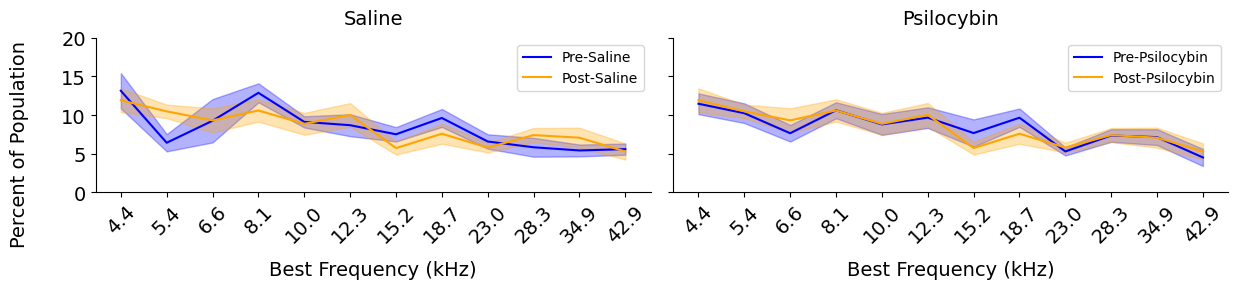

In [18]:
import matplotlib.pyplot as plt

# Create subplots with specified layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# First subplot (Saline)
ax1.plot(BF_mean_pre_saline, label='Pre-Saline', color='b')
ax1.plot(BF_mean_post_saline, label='Post-Saline', color='orange')
ax1.fill_between(x, BF_mean_pre_saline - BF_sem_pre_saline, BF_mean_pre_saline + BF_sem_pre_saline, color='b', alpha=0.3)
ax1.fill_between(x, BF_mean_post_saline - BF_sem_post_saline, BF_mean_post_saline + BF_sem_post_saline, color='orange', alpha=0.3)
ax1.set_yticklabels([0, 5, 10, 15, 20], fontsize=14)
ax1.set_ylim(0, 0.2)
ax1.legend()
ax1.set_title("Saline", pad=10, fontsize=14)

# Second subplot (Psilocybin)
ax2.plot(BF_mean_pre_psilo, label='Pre-Psilocybin', color='b')
ax2.plot(BF_mean_post_psilo, label='Post-Psilocybin', color='orange')
ax2.fill_between(x, BF_mean_pre_psilo - BF_sem_pre_psilo, BF_mean_pre_psilo + BF_sem_pre_psilo, color='b', alpha=0.3)
ax2.fill_between(x, BF_mean_post_psilo - BF_sem_post_psilo, BF_mean_post_psilo + BF_sem_post_psilo, color='orange', alpha=0.3)
ax2.set_ylim(0, 0.2)
ax2.set_yticklabels([0, 5, 10, 15, 20], fontsize=14)
ax2.set_title("Psilocybin", pad=10, fontsize=14)
ax2.legend()

# Set x-axis labels and ticks for both subplots
for ax in [ax1, ax2]:
    ax.set_xticks(x)
    ax.set_xticklabels(ticks, rotation=45, fontsize=14)
    ax.set_xlabel("Best Frequency (kHz)", labelpad=10, fontsize=14)

# Add a shared y-label
fig.text(-0.03, 0.5, 'Percent of Population', va='center', rotation='vertical', fontsize=14)

# Remove top and right spines from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout and spacing
plt.tight_layout()
plt.show()

In [13]:
# Get the counts for each BF value in each cohort
counts_saline_pre = get_counts(BF_saline_pre)
counts_saline_post = get_counts(BF_saline_post)
counts_psilo_pre = get_counts(BF_psilo_pre)
counts_psilo_post = get_counts(BF_psilo_post)

In [14]:
print(counts_saline_pre)

{0: 0.11400153022188217, 1: 0.06809487375669472, 2: 0.09334353481254781, 3: 0.12930374904361133, 4: 0.08951798010711554, 5: 0.07804131599081866, 6: 0.07804131599081866, 7: 0.09640397857689365, 8: 0.07268553940321347, 9: 0.06809487375669472, 10: 0.05967865340474369, 11: 0.05279265493496557}


In [15]:
def plot_counts(pre_dict,post_dict,label_pre,label_post):
    x = pre_dict.keys()

    y1 = list(pre_dict.values())
    y2 = list(post_dict.values())

    n=12
    r = np.arange(n)
    width = 0.25
    labels = ['4364', '5371', '6612', '8140', '10020', '12335', '15184', '18691', '23009', '28324', '34867', '42922']

    plt.bar(r, y1, color = 'b', 
        width = width, edgecolor = 'black', 
        label=label_pre) 
    plt.bar(r + width, y2, color = 'orange', 
        width = width, edgecolor = 'black', 
        label=label_post) 
  

    plt.ylim(0,0.14)
    plt.xticks(r + width/2,labels,rotation=45) 

    plt.ylabel("Probability")
    plt.xlabel("Best Frequency (Hz)")

    plt.legend() 
    plt.tight_layout  
    plt.show() 

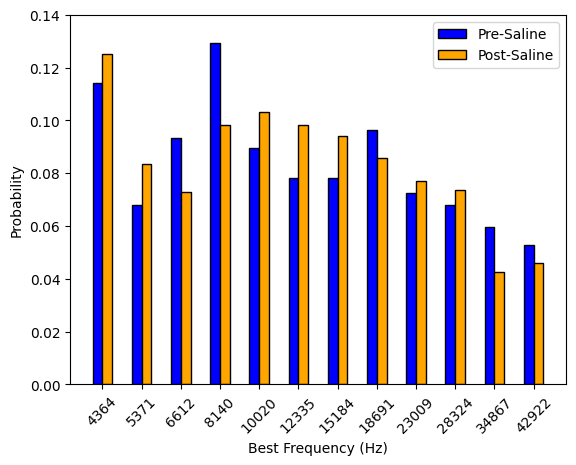

In [16]:
plot_counts(counts_saline_pre,counts_saline_post,'Pre-Saline','Post-Saline')

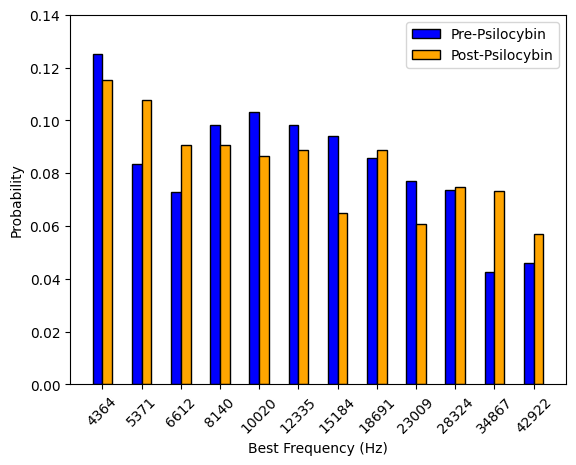

In [17]:
plot_counts(counts_saline_post,counts_psilo_post,'Pre-Psilocybin','Post-Psilocybin')

In [18]:
saline_KL = get_KL_divergence(counts_saline_post,counts_psilo_post)
print(saline_KL)

psilo_KL = get_KL_divergence(counts_psilo_pre,counts_psilo_post)
print(psilo_KL)

0.02399403045787804
0.00752336835167167


In [19]:
# Perform KS test between two samples
ks_statistic, p_value = ss.kstest(list(BF_psilo_pre), list(BF_psilo_post))

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.024019051876626406
P-value: 0.8658944646672477


MATCHED CELLS ANALYSIS:

In [31]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive

In [32]:
def find_max_column(arr):
    # Find the column index of the global maximum value in the flattened array
    global_max_index = np.argmax(arr)

    # Convert the flattened index to row and column indices
    row_index, global_max_column_index = np.unravel_index(global_max_index, arr.shape)

    return global_max_column_index

In [33]:
def get_BF_shifts_matched_cells(dict_pre,dict_post):

    BF_shifts_all = []

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):
        
        # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
        coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)

        # Initialize empty array to place BF's in.
        BF_shifts = np.zeros_like(coactive[:,0])

        # For each pair of cells in the coactive matrix, extract their tuning curves. i keeps track of the pair's row position. 
        for i,cell_1, cell_2 in zip(range(len(coactive[:,0])),coactive[:,0],coactive[:,1]):
                    tuning_array_1 = dict_pre[sub_dict_pre][cell_1]['peak_tuning']
                    tuning_array_2 = dict_post[sub_dict_post][cell_2]['peak_tuning']

                    BF_column = find_max_column(tuning_array_1)

                    BF_pre = tuning_array_1[:,BF_column]

                    BF_post = tuning_array_2[:,BF_column]

                    max_value_index1 = np.argmax(BF_pre)

                    max_value_index2 = np.argmax(BF_post)

                    BF_shift = max_value_index1 - max_value_index2

                    BF_shifts[i] = BF_shift
        
        BF_shifts_all.append(BF_shifts)

    BF_shifts_all = np.concatenate(BF_shifts_all)
    
    return BF_shifts_all  

In [34]:
BF_shifts_saline = np.abs(get_BF_shifts_matched_cells(saline_pre,saline_post))

BF_shifts_psilo = np.abs(get_BF_shifts_matched_cells(psilo_pre,psilo_post))

In [35]:
print(BF_shifts_saline)

[0 0 0 0 0 3 2 3 0 0 0 0 0 0 0 0 1 0 4 0 0 1 1 0 0 0 0 6 2 0 1 1 0 1 1 1 1
 1 0 7 1 2 5 6 0 0 0 1 1 0 2 0 0 4 0 2 0 0 1 0 2 1 2 0 6 3 3 1 0 3 4 0 4 1
 2 3 1 0 0 2 0 0 0 0 0 2 5 0 3 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3
 1 0 0 2 0 0 2 1 1 0 2 0 1 1 2 2 1 0 4 0 3 1 4 0 4 0 3 0 5 3 0 0 1 0 5 1 1
 0 0 0 5 4 0 1 0 8 1 1 0 6 0 5 0 0 0 0 0 0 9 0 4 0 1 2 3 0 0 1 5 5 0 3 5 1
 1 4 5 0 2 1 0 1 5 1 1 0 0 0 0 2 0 1 0 1 2 0 0 0 0 0 0 1 0 1 0 2 0 0 6 1 0
 3 3 2 0 5 4 0 0 0 0 3 0 0 0 0]


In [36]:
def bin_values(values):
    def bin_value(value):
        if value >= 0:
            return value // 2
        else:
            return (value + 1) // 2 - 1
    
    return [bin_value(val) for val in values]

In [37]:
bin_BF_shifts_saline = bin_values(BF_shifts_saline)
bin_BF_shifts_psilo = bin_values(BF_shifts_psilo)
print(bin_BF_shifts_saline)

[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 1, 1, 0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0]


(array([169.,   0.,  37.,   0.,   0.,  23.,   0.,   6.,   0.,   2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

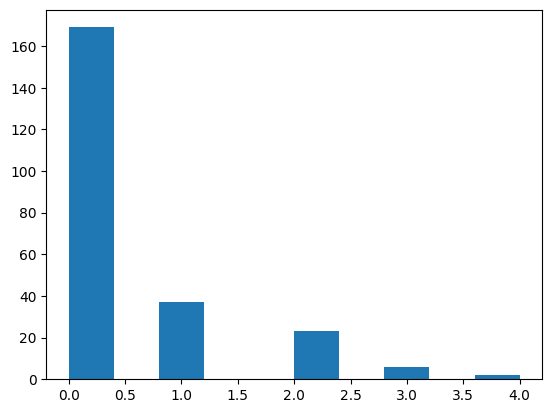

In [17]:
plt.hist(bin_BF_shifts_saline)

In [39]:
BF_shifts_counts_saline = get_counts(bin_BF_shifts_saline)
BF_shifts_counts_psilo = get_counts(bin_BF_shifts_psilo)

In [38]:
def equalize_dict_keys(dict_1,dict_2):
    for key in dict_1:
        if key not in dict_2:
            dict_2[key] = 0
    
    keys = list(dict_1.keys())
    keys = sorted(keys)
    dict_2_sorted = {i: dict_2[i] for i in keys}

    return dict_2_sorted

In [37]:
# # full = np.arange(-11,12,1)
# print(full)

# for key in full:
#             BF_shifts_counts_saline.setdefault(key, 0)
#             BF_shifts_counts_psilo.setdefault(key,0)


[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6
   7   8   9  10  11]


In [40]:
BF_shifts_counts_saline = equalize_dict_keys(BF_shifts_counts_psilo,BF_shifts_counts_saline)

In [41]:
print(BF_shifts_counts_saline)
print(BF_shifts_counts_psilo)

{0: 0.7130801687763713, 1: 0.15611814345991562, 2: 0.0970464135021097, 3: 0.02531645569620253, 4: 0.008438818565400843, 5: 0}
{0: 0.7132616487455197, 1: 0.0967741935483871, 2: 0.08960573476702509, 3: 0.06093189964157706, 4: 0.025089605734767026, 5: 0.014336917562724014}


In [42]:
def plot_counts_BF_shifts(pre_dict, post_dict, label_pre, label_post):
    x = list(pre_dict.keys())

    multiplied_dict_1 = {key: value * 100 for key, value in pre_dict.items()}
    multiplied_dict_2 = {key: value * 100 for key, value in post_dict.items()}

    y1 = list(multiplied_dict_1.values())
    y2 = list(multiplied_dict_2.values())

    # Ensure the number of bins (ticks) matches the number of data points
    n = len(y1)
    r = np.arange(n)
    width = 0.25
    labels = ['<1',1,2,3,4,5,6]

    # Make sure the labels list matches the number of bars to be plotted
    if len(labels) < n:
        labels.extend([''] * (n - len(labels)))  # Pad with empty strings if labels are fewer than data points

    plt.bar(r, y1, color='b', width=width, edgecolor='black', label=label_pre)
    plt.bar(r + width, y2, color='orange', width=width, edgecolor='black', label=label_post)

    plt.xticks(r + width/2, labels[:n],fontsize=14)  # Limit labels to the number of data points
    plt.yticks(fontsize=14)

    plt.ylabel("Percent of Population",fontsize=14,labelpad=10)
    plt.xlabel("Magnitude of Best Frequency Shift (Octaves)",fontsize=14,labelpad=10)

        # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # plt.title("Change in Best Frequency, Saline vs Psilocybin Conditions", pad=10)
    plt.legend(fontsize=14)
    plt.tight_layout()  # Call the function, not just reference it
    plt.show()

In [ ]:
print(multiplied_dict_1)

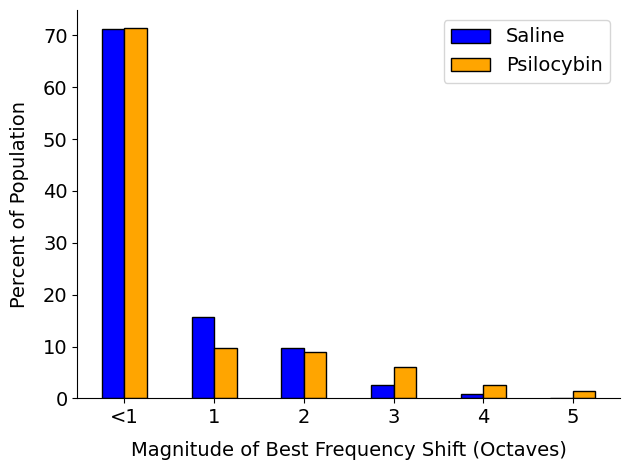

In [43]:
plot_counts_BF_shifts(BF_shifts_counts_saline,BF_shifts_counts_psilo,'Saline','Psilocybin')

PREFERRED INTENSITY ANALYSIS:

In [21]:
PI_shifts_saline = np.load('F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/PI_shifts_saline_neg.npy')
PI_shifts_psilo = np.load('F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/PI_shifts_psilocybin_neg.npy')

PI_shifts_saline = np.abs(PI_shifts_saline)
PI_shifts_psilo = np.abs(PI_shifts_psilo)

PI_shift_counts_saline = get_counts(PI_shifts_saline)
PI_shift_counts_psilo = get_counts(PI_shifts_psilo)

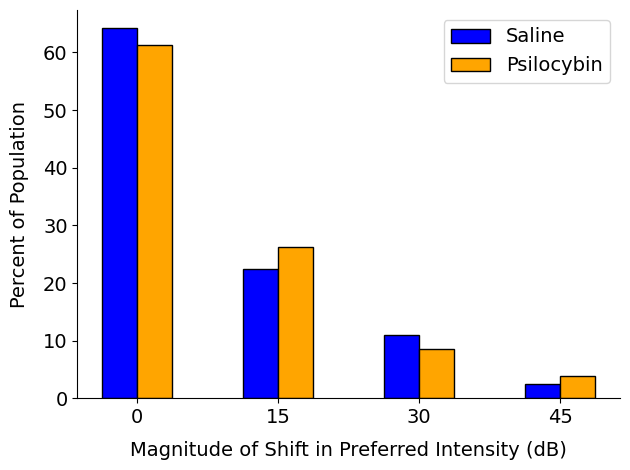

In [22]:
multiplied_dict_1 = {key: value * 100 for key, value in PI_shift_counts_saline.items()}
multiplied_dict_2 = {key: value * 100 for key, value in PI_shift_counts_psilo.items()}

y1 = list(multiplied_dict_1.values())
y2 = list(multiplied_dict_2.values())

    # Ensure the number of bins (ticks) matches the number of data points
n = len(y1)
r = np.arange(n)
width = 0.25
labels = ['0','15','30','45']

    # Make sure the labels list matches the number of bars to be plotted
if len(labels) < n:
    labels.extend([''] * (n - len(labels)))  # Pad with empty strings if labels are fewer than data points

plt.bar(r, y1, color='b', width=width, edgecolor='black', label='Saline')
plt.bar(r + width, y2, color='orange', width=width, edgecolor='black', label='Psilocybin')

plt.xticks(r + width/2, labels[:n],fontsize=14)  # Limit labels to the number of data points
plt.yticks(fontsize=14)

plt.ylabel("Percent of Population",fontsize=14,labelpad=10)
plt.xlabel("Magnitude of Shift in Preferred Intensity (dB)",fontsize=14,labelpad=10)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

    # plt.title("Change in Best Frequency, Saline vs Psilocybin Conditions", pad=10)
plt.legend(fontsize=14)
plt.tight_layout()  # Call the function, not just reference it
plt.show()

In [59]:
print(multiplied_dict_2)

{0: 61.29032258064516, 1: 26.16487455197133, 2: 8.60215053763441, 3: 3.942652329749104}
